#  <p style ="text-align:center"> Option A: Epidemiology </span> 

## Setting

> We are a consulting agency that has been hired by Mayor Bill De Blasio to gauge the preparedness of New York in the event of a Pathological Bio-Terrorist Attack on Manhattan using the Small Pox disease. 



* Inspired by the ["smallpox questions and answers"](https://www.ndhealth.gov/WebcastHTML/20021205/smallpox%20questions%20and%20answers.pdf) document by the Centers for Disease Control and Prevention

## Audience
* Military
* Government 
* Health Care Industry

## Primary Question 

> Is New York City equipped to contain, quarantine and recover from a Pathological Bio-Terrorist Attack using the Small Pox disease. 
  


### Secondary Question 1 
>At what time will the infected population peak and what will be their magnitude?


### Secondary Question 2
> How long will it take to contain the outbreak?

### Secondary Question 3
>How many people will die throughout the simulation? 

# <p style = "text-align: center"> Populations Under Consideration </p>

<img src="SIRED.png" alt="SIRD Flow Diagram" height="50%" width="50%">


## S
* Susceptible Population i.e. the factor of the total population that can still get infected.
* The susceptible population can only transition into the Recovered or Infected sub-group. 

## I
* Infected Population i.e. the factor of the total population that is infected by the pathogen. 
* The infected population can only transition into the Recovered or Dead sub-groups.  

## R
* Recovered Population i.e. the factor of the total population that has recovered from the disease and/or is immune from any further infection.
* The recovered population cannot transition into any other sub-group. 

## E
* Escapee population i.e. the factor of the total population that escapes from the City.
* The escapee population cannot transition into any other sub-group. 

### D
* The factor of the population that has died as a consequence of the disease.
* The dead population cannot transition into any other sub-group. 

# Assumptions

* The Smallpox disease has evolved.
* Acceptable Loss: The acceptable threshold for the death toll is at most 10% of the target population.
* Infected death probability will exhibit historical trends.
* The vaccine only works on the uninfected population. 
* Vaccination results in spontaneous immunity w/o side effects.
* The simulation runs until everyone either recovers or dies.
* The contact rate is based on disease incubation, after which it becomes contagious. 
* Smallpox recovery will take approximately the number of days equivalent to the sum of the contagious phases. 
* If less than (0.0000001 x Total Population) is infected, then that value is approximated as zero.
* Central Park and its neighbors are Ground Zero.


### Facts and Figures
* NYC Initial Population: ~1.6 Mil ([World Population Review](http://worldpopulationreview.com/boroughs/manhattan-population/))
* Central Park is the Weapon Detonation Site. 42 Mil. Visit Central Park/Year ([Smithisonian](https://www.smithsonianmag.com/travel/12-secrets-new-yorks-central-park-180957937/))=> (42/365)* 1000000 = ~115000 people per day 
* Small Pox Death Probability         : 30% (pp.1, smallpox questions and answers, ([Illinois Department of Public Health](http://www.idph.state.il.us/Bioterrorism/smallpoxfctsht.htm), [Health NY](https://www.health.ny.gov/publications/7004/))    ~= 50%    
* Small Pox Infection Contact Rate    : 7-14 days (pp.1, smallpox questions and answers)    ~= 3   
* Small Pox Recovery Rate w/o vaccine : 20 (added up days for contagious periods given here 
[CDC.GOV](https://www.cdc.gov/smallpox/symptoms/index.html)      ~= 30  : 

# Expectations before Programming
* The disease will initially spready very fast. 
* A good portion of the population, 1/3, will die off without vaccines or medical treatment. 
* After a vaccine is introduced, the number should go down dramatically. 


# <p style ="text-align:center">Simulation Source Code</p>

## Library Imports

In [1]:
# State objects etc. https://github.com/AllenDowney/ModSimPy
from modsim import *

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# Modsim Dependency 
!pip install pint                   

# Plotting  
import matplotlib.pyplot as plt      
import pandas as pd

# Configure Jupyter so figures appear in the notebook
%matplotlib inline                   

# Floor
import math             

# Simulation Methods

## Base Simulation, Base Update Function and Plotting

In [2]:
'''
'Creates a modsim System object which works as a collection of system arguments.  
'@param  susc         : The initial Susceptible Population.  
'@param  inf          : The initial Infected Population. 
'@param  contact_rate : The number of days used to determine the Contact  Rate. 
'@param  recovery_rate: The number of days used to determine the Recovery Rate.
'@param  escape_rate  : The number of days used to determine the Escape   Rate.
'@param  death_rate   : The number of days used to determine the Death    Rate.
'@return System       : Modsim object that represents the System for the simulaton. 
'''
def make_system(susc=0, inf=0, 
                contact_rate=0, recovery_rate=0, escape_rate=0, death_rate=0, 
                inter_funcs=None, func_args=None):

    init   = State(S=susc, I=inf, R=0, E=0, D=0)
    init  /= sum(init)
    t0     = 0
    
    return System( init          = init,  
                   t0            = t0,
                   contact_rate  = 0 if (contact_rate  == 0) else  1/contact_rate , 
                   recovery_rate = 0 if (recovery_rate == 0) else  1/recovery_rate,
                   escape_rate   = 0 if (escape_rate   == 0) else  1/escape_rate  , 
                   death_rate    = 0 if (death_rate    == 0) else  1/death_rate   ,
                   inf_tally     = inf, 
                   total_pop     = susc +  inf,
                   inter_funcs   = inter_funcs, 
                   func_args     = func_args   )

'''
'Mutates the state of the system at time (t) based on system arguments and the state at time (t-1)
'@param  state        : System state configuration at time 't' 
'@param  t            : Time 't' elapsed since the start of the simulation. 
'@param  system       : The System variable that contains the different rates and other values.  
'@return State        : The state of the Sytem after the update funciton has mutated it. 
'''
def base_update_function(state, system):
     
    s = state.S 
    i = state.I
    r = state.R
    e = state.E
    d = state.D 
    
    infected  = system.contact_rate  * i * s     
    recovered = system.recovery_rate * i
    escapees  = system.escape_rate   * s 
    dead      = system.death_rate    * i  
    
    s        -= (infected + escapees)
    i         = 0 if i + (infected - recovered - dead) <= 0 else i + (infected - recovered - dead)  
    r        += recovered
    e        += escapees
    d        += dead 
    
    system.inf_tally += 0 if(infected < 0) else math.ceil(system.total_pop * infected); 
    
    return State(S=s, I=i, R=r, E=e, D=d)


'''
'@param  system       :  The System variable that contains the different rates and other values. 
'@param  update_fun   :  function that updates state
'@return State        :  State object configuration by the end of the simulation. 
'''

def run_base_simulation(system, update_func):
        
    state = system.init
    time  = system.t0
    frame = TimeFrame(columns=system.init.index) 
    frame.row[time] = system.init
    
    while(frame.row[time].I > 0.00001):
        time            += 1
        frame.row[time]  = update_func(frame.row[time-1], system)
    return frame



## Plotting

In [3]:
"""
'Plots the results of a SIRED model.
'@param results : DataFrame object. 
'@param title   : The title of the graph. 
'@param w       : an integer that represents the width. 
'@param h       : an integer that represents the height.
'@return void
"""

def plot_results(results, title="",w=8, h=5):
    fig, ax = plt.subplots(figsize=(w,h))
    plt.title(title)
    ax.plot(results.S, '--' ,  label =  'Susceptible')
    ax.plot(results.I, '-'  ,  label =  'Infected'   )
    ax.plot(results.R, '-.' ,  label =  'Recovered'  )
    ax.plot(results.E, '-'  ,  label =  'Escapees'   )
    ax.plot(results.D, ':'  ,  label =  'Dead'       )
    ax.grid(b=None, which='major', axis='both')
    plt.legend(loc='upper center', bbox_to_anchor=(1.25, .75), shadow=True, ncol=1)
    decorate(xlabel='Time (days)', ylabel='Fraction of population')
    if len(results.index) > 50:
        plt.xticks(range(0, len(results.index), 5), fontsize = 15)
    plt.yticks(make_index())
    plt.show()

"""
'Plots the results of the SIRED model sweeps.
'@param results : DataFrame object. 
'@param title   : The title of the graph. 
'@param w       : threshold which controls what x-axis tick is highlighted. 
'@param w       : an integer that represents the width. 
'@param h       : an integer that represents the height.
'@return void
"""

def plot_metrics(results,w=8,h=5,target=10.0, title=""):
    fig, ax = plt.subplots(figsize=(w,h))
    plt.title(title)
    ax.grid(b=None, which='major', axis='both')
    ax.plot(results.Unaffected, '--' , label =  'Unaffected')
    ax.plot(results.Infected  , '-'  , label =  'Infected'  )
    ax.plot(results.Recovered , '-.' , label =  'Recovered' )
    ax.plot(results.Dead      , ':'  , label =  'Dead'      )
    plt.xticks(range(len(results.index)), results.Fraction.astype(str), 
               rotation = (90), fontsize = 16, va='top', ha='right')
    plt.yticks(range(0,100,10))
    plt.ylim([0, 100])
    plt.legend(loc='upper center' , bbox_to_anchor=(1.25, .75), shadow=True, ncol=1)
    decorate(xlabel='Fraction' , ylabel= '% Population at the end of Run-Time')
    index = find_first_instanceOf(target, results.Dead ) 
    ax.get_xticklabels()[index].set_color("red")
    
    plt.show()
    
"""
'Returns the index of the first occurance of a target value in a given data structure.  
'@param target : The value whoes index is being sought.  
'@param data   : The title of the graph. 
'@return integer
"""
def find_first_instanceOf(target, data):
    for index, i  in enumerate(data, start=0):
        if(i <= target):
            return index 
    return 0

""" 
'@return list  : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
""" 
def make_index():
    a = list()
    num = 1 
    for i in range(10):
        a.append(num)
        num-=.1

## Metric and Report Generation

In [4]:
'''
'@param results : DataFrame that contains the results for the simulation.
'@param system  : System Object that represents the System, Parameters etc.
'@param fract   : Used during sweeping. Represents whatever the intervention fraction is.
'@param return void'
'''
def calculate_metrics(results, system, frac=0):
    population   = system.total_pop
    recPercent   = calculate_percent(calculate_total_recovered(results       , system), population) 
    unaffPercent = calculate_percent(calculate_unaffected(results,system)    , population) 
    deathPercent = calculate_percent(calculate_death_toll(results,system)    , population)  
    infPercent   = calculate_percent(calculate_total_infected(results,system), population)
    return State(Fraction=frac, Unaffected=unaffPercent, Infected=infPercent, Recovered=recPercent, Dead=deathPercent)

'''
'@param results : DataFrame that contains the results for the simulation.
'@param system  : System Object that represents the System, Parameters etc.
'@param return void'
'''
def print_metrics(results, system):
    population   = system.total_pop
    unaff        = calculate_unaffected(results,system)
    unaffPercent = calculate_percent(unaff, population) 
    esc          = calculate_escaped(results,system) 
    escPercent   = calculate_percent(esc, population) 
    deathToll    = calculate_death_toll(results,system)
    deathPercent = calculate_percent(deathToll, population)  
    infected     = calculate_total_infected(results,system)
    infPercent   = calculate_percent(infected, population)
    maxInf       = calculate_max_infected(results, system)
    maxInfDay    = find_max_infected_day(results) 
    recovered    = calculate_total_recovered(results, system)
    recPercent   = calculate_percent(recovered, population) 
    print("The Simulation ran for\t\t:"     , results.index[-1],"days" )
    print("Total Initial Population\t:"     , population)
    print("% Population Unaffected\t\t:"    , unaffPercent , "%\t With Magnitude:\t" , unaff    )
    print("% Population Infected\t\t:"      , infPercent   , "%\t With Magnitude:\t"  , infected )
    print("% Population Recovered\t\t:"     , recPercent   , " %\t With Magnitude:\t" , recovered)
    print("% Population Dead\t\t:"          , deathPercent , "%\t With Magnitude:\t"  , deathToll)
    print("% Population Escaped\t\t:"       , escPercent   , " %\t With Magnitude:\t" , esc      )
    print("Maximum Infected on Day\t\t:"    , maxInfDay    , "\t\t With Magnitude:\t" , maxInf   )
    

    
# Helper Methods, left as methods instead of one-liners because of easier abstraction

def calculate_unaffected(results,system):
    return math.ceil(results['S'].tail(1)*system.total_pop)

def calculate_escaped(results,system):     
    return math.ceil(results['E'].tail(1)*system.total_pop)


def calculate_death_toll(results, system):
    return math.ceil(results['D'].tail(1)*system.total_pop)

def calculate_max_infected(results, system):
    return math.ceil(results['I'].max()*system.total_pop)  
                
def find_max_infected_day(results):
    return results['I'].idxmax() 
             
def calculate_total_infected(results, system):
    return system.inf_tally

def calculate_total_recovered(results, system):
    return math.ceil(results['R'].tail(1)*system.total_pop)

def calculate_percent(fraction, totalPop):
    return round( (fraction / totalPop) * 100 , 3 )

def line():
    linebreak= ""
    for i in range(100):
        linebreak += "-"
    return linebreak 

# Base Simulation Configuration and Execution

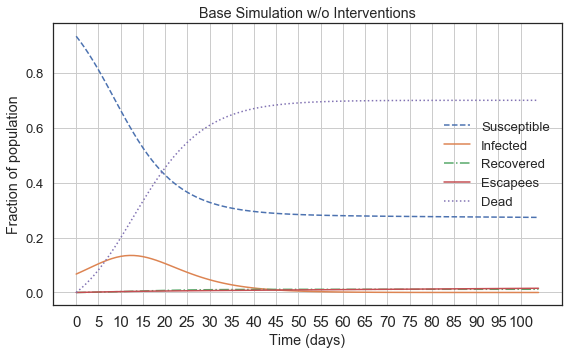

The Simulation ran for		: 104 days
Total Initial Population	: 1715000
% Population Unaffected		: 27.337 %	 With Magnitude:	 468834
% Population Infected		: 71.132 %	 With Magnitude:	 1219910
% Population Recovered		: 1.166  %	 With Magnitude:	 19998
% Population Dead		: 69.962 %	 With Magnitude:	 1199846
% Population Escaped		: 1.534  %	 With Magnitude:	 26308
Maximum Infected on Day		: 12 		 With Magnitude:	 231238


In [5]:
initial_susceptible = 1600000
initial_infected    = 115000
contact_days        = 3
recovery_days       = 300
death_days          = 5
escape_days         = 2500
system              = make_system( initial_susceptible, initial_infected,
                                   contact_days, recovery_days, 
                                   escape_days , death_days   )
results = run_base_simulation(system, base_update_function)
plot_results(results, "Base Simulation w/o Interventions")
print_metrics(results, system)

# <p style = "text-align:center"> Interventions </p> 

## 1. Vaccinations

In [6]:
def add_vaccinations(state, system, fract):
    vaccinated = fract * state.S 
    return vaccinated 

## 2. Disease Screenings

In [7]:
def add_screenings(state, system, fract):
    detected = fract * state.I
    return detected

## 3. Education Campaign

In [8]:
def add_disease_education_camp(state, system, fract):
    suscEdu = state.S * fract  
    infEdu  = state.I * fract
    return [suscEdu, infEdu]

# <p style = "text-align:center"> Parameter Sweeps </p> 
> Goal: Reduce the death rate to 10%.

## New Update Function  and Sweep Template

In [9]:
'''
' The new update function that expects the system variable to contain an array of intervention functions and function arguments. 
'@param state  : System state configuration at time 't'. 
'@param system : The System variable that contains the different rates and other values.
                 All fields must be defined for this state object. See make_system.
'@return State : a state object that represents all of the updated populations.   
'''
def inter_update_function(state, system):
    
    s = state.S 
    i = state.I
    r = state.R
    e = state.E
    d = state.D 
    
    vaccinated = system.inter_funcs[0](state, system, system.func_args[0])
    screened   = system.inter_funcs[1](state, system, system.func_args[1])
    educated   = system.inter_funcs[2](state, system, system.func_args[2])
    
    infected   = system.contact_rate  * i * s    
    recovered  = system.recovery_rate * i
    escapees   = system.escape_rate   * s 
    dead       = system.death_rate    * i  
    
    s         -= infected  + escapees   + vaccinated + educated[0]   
    i         += infected  - recovered  - screened   - dead         - educated[1]
    r         += recovered + vaccinated + screened   + educated[0]  + educated[1]
    e         += escapees
    d         += dead 
  
    # For logical consistency
    i          = 0 if i < 0 else i
    s          = 0 if s < 0 else s
    
    system.inf_tally += 0 if(infected < 0) else math.ceil(system.total_pop * infected); 
    
    return State(S=s, I=i, R=r, E=e, D=d) 


# Defaul List of Intervention Methods
inter_funcs = [add_vaccinations, add_screenings, add_disease_education_camp]
inter_names = thisdict = { "vaccinate": 0, "screen": 1, "educate": 2}



'''
'Function that allows the sweeping of any intervention, as long as its defined and available in the system object. 
'@param interName  :  'Selected Name' that belongs to inter_names. 
'@param inter_names:  The System variable that contains the different rates and other values.
'@param inter_funcs:  An iterable collection of functions.  
'@param upperBound :  The number of divisions between [0,1]
'@param title      :  The name of the graph that will be plotted at the end. 
'@return State : a state object that represents all of the updated populations.   
'''

def sweep(interName, inter_names, inter_funcs, upperBound=30, title =""):
    title += " Sweep"
    func_args           = [0,0,0]
    initial_susceptible = 1600000
    initial_infected    = 115000
    contact_days        = 3
    recovery_days       = 30
    death_days          = 5
    escape_days         = 2500
    linebreak           = line()
    results             = TimeFrame(columns=["Fraction","Dead","Infected","Recovered","Unaffected"])
    t = 0
    for fract in linspace(0, 1, upperBound):    
        func_args[inter_names[interName]] = fract
        
        system          = make_system(initial_susceptible, initial_infected, 
                              contact_days, recovery_days,escape_days, death_days,
                              inter_funcs, func_args)
        data            = run_base_simulation(system, inter_update_function)
        results.row[t]  = calculate_metrics(data, system, round(fract,3))
        t+=1
    plot_metrics(results, title=title)

                

## Single Source Optimal 

## Vaccination Sweep

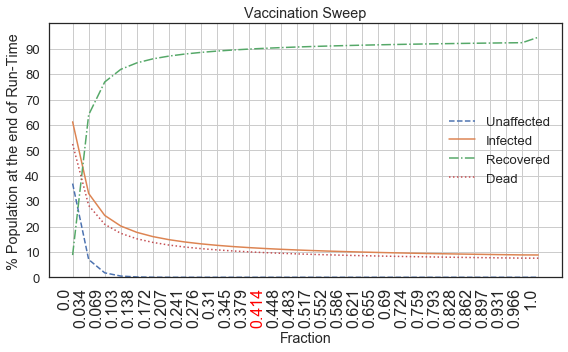

In [10]:
sweep("vaccinate", inter_names, inter_funcs,30,title="Vaccination")

## Vaccination Sweep Result
Must vaccinate approximatly **0.414** of the susceptible population to bring the death rate down to 10%.


## Screenings Sweep

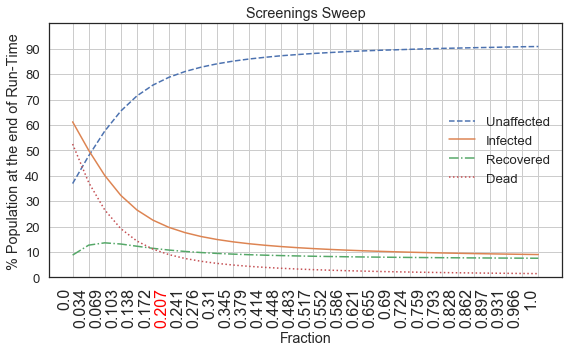

In [11]:
sweep("screen", inter_names, inter_funcs, title="Screenings")

## Screening Sweep Result
Must screen approximatly **0.207** of the susceptible population to bring the death rate down to 10%.

## Disease Education Campaign Sweep

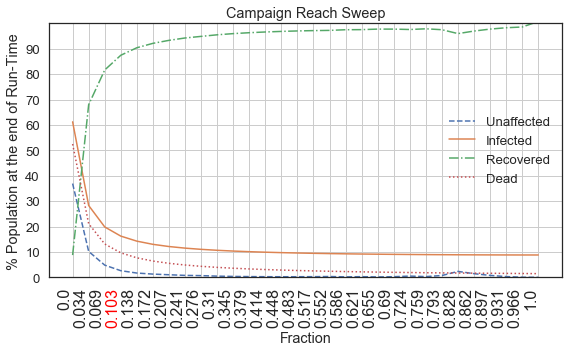

In [12]:
sweep("educate", inter_names, inter_funcs, title="Campaign Reach")

## Educating Campaign Sweep Result
The education campaign must reach approximatly **0.103** of the infected and susceptible populations per day to bring the death rate down to 10%.

# Final Simulation

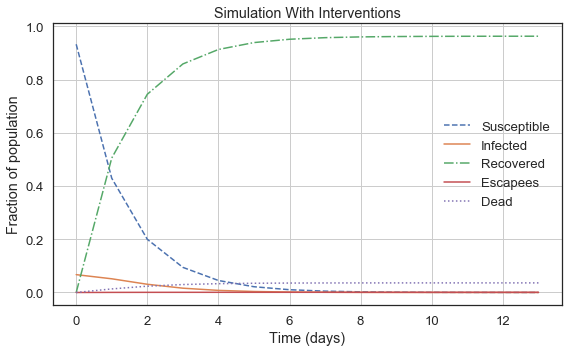

The Simulation ran for		: 13 days
Total Initial Population	: 1715000
% Population Unaffected		: 0.006 %	 With Magnitude:	 109
% Population Infected		: 9.8 %	 With Magnitude:	 168068
% Population Recovered		: 96.316  %	 With Magnitude:	 1651826
% Population Dead		: 3.607 %	 With Magnitude:	 61858
% Population Escaped		: 0.07  %	 With Magnitude:	 1196
Maximum Infected on Day		: 0 		 With Magnitude:	 115000


In [13]:
# Regular System Variables.
initial_susceptible = 1600000
initial_infected    = 115000
contact_days        = 3
recovery_days       = 30
death_days          = 5
escape_days         = 2500

# Intervention Fractions, as determined by Sweeping.
vaccinations_fract  = .414
screenings_fract    = .207
edu_fract           = .103

inter_funcs         = [add_vaccinations, add_screenings, add_disease_education_camp] 
func_args           = [vaccinations_fract, screenings_fract, edu_fract]
system              = make_system(initial_susceptible, initial_infected, 
                                      contact_days, recovery_days,escape_days , death_days,
                                      inter_funcs, func_args)
results             = run_base_simulation(system, inter_update_function)

plot_results(results, "Simulation With Interventions")
print_metrics(results, system)